# Competitor Analysis Using Multi-Agent Retrieval-Augmented Generation (RAG) Collaborative System
#Developer: Nilovna Chatterjee, PhD

## Business Context
Performing competitor analysis with a Multi-Agent Retrieval-Augmented Generation (RAG) Collaborative System.

## Problem Scenario
Conducting a robust competitor analysis of a company is a time-consuming and research-intensive process that may be prone to errors for example, outdated information.

Analysts spend significant time gathering data, identifying relevant competitors, and synthesizing insights into actionable recommendations.

## Objective
To address above mentioned challenges, a Multi-Agent Retrieval-Augmented Generation (RAG) Collaborative System is proposed.

This system will perform competitor analysis of a given company by comparing it with its key rivals in the relevant industry using the latest available web data.

Users will input a company name (e.g., "Tesla") and receive a well-structured report, comparing that company to its primary competitors (e.g., in the electric vehicle sector for Tesla), by leveraging a multi-agent collaborative architecture powered by RAG capabilities.

The system should deliver rapid, accurate, and actionable insights.

## Solution Approach

A Multi-Agent Retrieval-Augmented Generation (RAG) Collaborative System is implemented using a sequential workflow pattern.

This system automates competitor analysis by breaking down the task into distinct steps handled by specialized agents.

The sequential pattern ensures each step builds on the previous one. Also, incorporating RAG to retrieve and augment data from a vector database for context-aware insights.


**Below are the key components of the implementation:**

### State Management

The workflow uses a Pydantic-based state `CompetitiveAnalysisState` to track variables like company name, generated questions, search results, vectorstore status, and the final report.

### Tools
- `suggest_questions`: Generates relevant questions for competitor analysis using the LLM.
- `fetch_search_results`: Searches the web via Tavily API to fetch answers for the questions.
- `store_in_chromadb`: Stores question-answer pairs in ChromaDB for efficient retrieval.
- `generate_report`: Uses RAG to query the vectorstore and draft a structured report.




### Agents

- `Question Generator Agent`: Validates the company, identifies its sector, and generates analysis questions.

- `Data Retrieval and Storage Agent`: Fetches answers from the web and stores them in the vector database.

- `Report Drafter Agent`: Retrieves stored data via RAG and generates a professional, actionable report with sections like Executive Summary, Company Overview, Key Competitors, Strengths/Weaknesses, Market Strategies, and Recommendations.




### Workflow (Sequential Pattern)

The system uses LangGraph's StateGraph to define nodes for each agent.
Edges connect the nodes sequentially as indicated below.

`START → Question Generation → Data Retrieval/Storage → Report Drafting → END.`

The final output is formatted competitive analysis report, displayed in Markdown for readability.

# Installing the Libraries

Installing the libraries:
- **openai==1.99.9** → Official OpenAI client library for interacting with GPT models.  
- **langchain==0.3.27** → Core framework for building applications powered by LLMs.  
- **langchain-openai==0.3.30** → LangChain integration for OpenAI models.  
- **langchain-community==0.3.27** → Community-contributed LangChain modules (tools, integrations).  
- **langgraph==0.6.4** → Build and manage multi-step workflows or agent graphs for LLM-powered systems.  
- **langchain-chroma==0.2.5** → Connector for using **ChromaDB** as a vector database with LangChain.  
- **chromadb==1.0.16** → Open-source vector database for storing and retrieving embeddings.  
- **langchain-tavily==0.2.11** → Integration for the **Tavily API** (specialized web search + retrieval for RAG).  

In [8]:
#Install required packages
!pip install -q openai==1.99.9 \
                langchain==0.3.27 \
                langchain-openai==0.3.30 \
                langchain-community==0.3.27 \
                langgraph==0.6.4 \
                langchain-chroma==0.2.5 \
                chromadb==1.0.16 \
                langchain-tavily==0.2.11

# Setting up the Environment (5 Marks)

## **Importing the relevant packages**

In [11]:
import os
import json
import random
import datetime

from typing import TypedDict, List, Optional, Dict, Tuple

from pydantic import BaseModel, Field,ConfigDict

import chromadb

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import StructuredTool
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langchain_core.retrievers import BaseRetriever # Corrected from 'retriever' to 'retrievers'
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent
from langchain_tavily import TavilySearch

from IPython.display import Image, display, Markdown

from google.colab import userdata

## **Instantiating the required variables (5 Marks)**

Set the environment variables.

To securely connect with external APIs (like OpenAI and Tavily), we’ll set up our **environment variables**.  
This ensures our API keys are not hard-coded directly in the notebook, keeping them safe.

- **OPENAI_API_KEY**
- **OPENAI_BASE_URL**
- **TAVILY_API_KEY**

After running this cell, your notebook will be able to access both **OpenAI** and **Tavily APIs** securely.


In [14]:
# Set environment variables
openai_api_key = userdata.get('OPEN_API_KEY')
os.environ["OPEN_API_KEY"] = openai_api_key
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
os.environ['OPENAI_BASE_URL'] = "https://aibe.mygreatlearning.com/openai/v1"

Now that our environment variables are set, let's initialize the **core models** we'll use in this project:

Instantiating the LLM and the embedding model using the `ChatOpenAI` and `OpenAIEmbeddings` methods respectively.

In [15]:
# Instantiate LLM
llm = ChatOpenAI(
    api_key=openai_api_key,
    base_url=os.environ['OPENAI_BASE_URL'],
    model='gpt-4o-mini',
    temperature=0
)

# Initialize OpenAIEmbeddings
embedding_model = OpenAIEmbeddings(
    api_key=openai_api_key,
    base_url=os.environ['OPENAI_BASE_URL'],
    model='text-embedding-3-small'
)

To enable **Retrieval-Augmented Generation (RAG)**, we need a place to store and query text embeddings.  
Here, we'll use **ChromaDB**, an open-source vector database.

Setting up the Chroma vector database client and a Chroma vector store collection for storing and retrieving search results.

In [16]:
# ChromaDB set up Persistent client
#Set up Vector Store

# ChromaDB Setup
chromadb_client = chromadb.PersistentClient(path="./assist_db")
vectorstore = Chroma(
    collection_name="search_result_collection",
    collection_metadata={"hnsw:space": "cosine"},
    embedding_function=embedding_model,
    client=chromadb_client,
    persist_directory="./assist_db"
)


# **State Definitions (6 Marks)**

Lets define the Pydantic models for structured outputs - 'QuestionSuggestion' and the overall state - 'CompetitiveAnalysisState'  .
State Definition ensure type safety and structure the data passed between agents and nodes.

## **QuestionSuggestion (3 Marks)**


This model will help ensure that the responses from the LLM follow a **consistent format**, making them easier to validate and use later.

- Create a class that inherits from `BaseModel`.  
- Fields include:
  - **sector** → The industry sector of the company.  
  - **is_valid_company** →  A boolean flag for whether the company name is recognized.  
  - **questions** → A list of suggested competitive analysis questions.  
  - **error_message** → Optional field to capture any errors that occur.  

- The `Field()` argument ensures that **default values** and **descriptions** are available for each attribute.  


In [18]:
# First, define the constant as required
MAX_NUM_OF_QUESTIONS = 40

class QuestionSuggestion(BaseModel):
    """
    Structured output model for competitive analysis questions
    """
    sector: str = Field(None, description="The industry sector the company operates in")
    is_valid_company: bool = Field(..., description="Whether the provided company name is valid/known")
    questions: List[str] = Field(default_factory=list, description="List of generated competitive analysis questions")
    error_message: Optional[str] = Field(None, description="Error message if any step fails")

class CompetitiveAnalysisState(BaseModel):
    company_name: str
    # Now MAX_NUM_OF_QUESTIONS is defined and can be used as a default
    max_num_of_questions: int = MAX_NUM_OF_QUESTIONS
    sector: Optional[str] = None
    is_valid_company: Optional[bool] = None
    question_list: Optional[List[str]] = None
    qna_results: Optional[List[Dict]] = None
    vectorstore: Chroma = vectorstore
    chromadb_insert_status: Optional[bool] = None
    report: Optional[str] = None
    error_message: Optional[str] = None
    model_config = ConfigDict(arbitrary_types_allowed=True)

## **Competitive Analysis State (3 marks)**

Next, we’ll create a state object for keeping track off the competitive analysis that keeps track of all the information our pipeline generates and updates during the competitive analysis workflow.

This will act as a “shared memory” object, making it easier to pass data between steps in the system.

- Fields include:
  - **company_name** → The company being analyzed.  
  - **max_num_of_questions** → The maximum number of questions to generate (use a constant as the default).  
  - **sector** → The industry sector (optional).  
  - **is_valid_company** → Boolean flag to mark if the company is recognized (optional).  
  - **question_list** → List of generated analysis questions (optional).  
  - **qna_results** → Stores answers to questions as a list of dictionaries (optional).  
  - **vectorstore** → Chroma vector database instance for retrieval.  
  - **chromadb_insert_status** → Tracks whether data was successfully stored in Chroma (optional).  
  - **report** → Final competitive analysis report (optional).  
  - **error_message** → Captures any error details (optional).

- The `model_config` setting allows **non-Pydantic types** (e.g., Chroma objects).


In [63]:
#Setting maximum limit to number of genetated questions
MAX_NUM_OF_QUESTIONS = 40

In [66]:
class CompetitiveAnalysisState(BaseModel):
    company_name: str
    max_num_of_questions: int # Set up to Maximum Number of Questions
    sector: Optional[str] = None
    is_valid_company: Optional[bool] = None
    question_list: Optional[List[str]] = None
    qna_results: Optional[List[Dict]] = None
    vectorstore: Chroma = vectorstore
    chromadb_insert_status: Optional[bool] = None
    report: Optional[str] = None
    error_message: Optional[str] = None
    model_config = ConfigDict(arbitrary_types_allowed=True)

# **Tools (13 Marks)**

## **Tavily Search Tool (1 Mark)**

To enrich our competitive analysis, **Tavily Search** will be used to fetch **relevant company information** that can later be embedded into our vector store and used for RAG.
The following code
- Initializes a `TavilySearch` instance with the following parameters:
  - **max_results** → The maximum number of results to return  
  - **include_answer** → Whether to include a synthesized answer from Tavily.  
  - **include_raw_content** → Whether to return raw page content along with the results.
  - **search_depth** → Set the level of search (`"basic"` or `"advanced"`).  

In [19]:
# Tavily Search Tool (1 Mark)
search = TavilySearch(max_results=2, include_answer=True, include_raw_content=True, search_depth="advanced")

Below section defines the tools used by the agents for,
- Suggesting questions,
- Fetching search results,
- Storing data in ChromaDB, and
- Generating the report.

## **Suggest Questions Tool (3 marks)**


The Suggest Questions Tool is a **custom LangChain tool** that uses an LLM to generate structured competitive analysis questions for a given company.  

This tool will serve as the **entry point** in our pipeline for validating company information and generating insightful prompts for deeper analysis.

The function `suggest_questions` contains a  **prompt** that instructs the LLM to:
     - Validate if the company is real/known.  
     - Identify its sector.  
     - Generate targeted competitor analysis questions (e.g., competitors, pricing, supply chain, strengths/weaknesses, market opportunities) and **invokes the LLM** with a structured output format (using the `QuestionSuggestion` model).  
The `@tool` decorator ensures that it can be called by agents within LangChain.


In [46]:
 # Define LangChain Tool
# Suggest Questions Tool
@tool
def suggest_questions(company_name: str, max_num_of_questions: int) -> str:
    """Suggest list containing questions for the given company name."""
    # Ensure the tool respects the absolute limit of 40 defined in the state
    limit = min(max_num_of_questions, 40)

    prompt = f"""
For the given company name: {company_name}

1. Validate if it's a known company: Set 'is_valid_company' to true if it's a recognized company; otherwise, false.
2. Identify its primary 'sector'.
3. Generate up to {limit} targeted questions for a comprehensive competitor analysis. Focus on areas that enable detailed comparisons and insights:
   - Identifying key competitors and market share.
   - Comparing products, pricing, technology, and supply chain.
   - Analyzing strengths, weaknesses, and differentiators.
   - Exploring market trends and growth opportunities.
Ensure questions support a structured report with sections like Executive Summary, Company Overview, Key Competitors, Strengths/Weaknesses, and Recommendations.
"""
    print("[INSIDE TOOL] suggest_questions")
    try:
        # Enforce structured output using the Pydantic model
        structured_llm = llm.with_structured_output(QuestionSuggestion)
        result = structured_llm.invoke(prompt)

        print(f"[Identified SECTOR] {result.sector}")
        print(f"[IS VALID COMPANY] {result.is_valid_company}")
        print(f"[QUESTION GENERATED LIST] {len(result.questions)} questions")

        return json.dumps({
            "sector": str(result.sector),
            "is_valid_company": bool(result.is_valid_company),
            "questions": result.questions
        })
    except Exception as e:
        print(f"Error: {str(e)}")
        return json.dumps({
            "sector": "",
            "is_valid_company": False,
            "questions": [],
            "error_message": str(e)
        })



## **Fetch Search Result Tool (3 Marks)**

The Fetch Search Result tool will take each question, query the **Tavily Search API**, and collect the results.

The function **iterates** through the `question_list` and for each question:
     - Call `search.invoke({"query": question})` to get Tavily search results.  
     - Check if the result contains an `"answer"`.  
     - Store the pair (`question`, `answer`) in a list of dictionaries.  
Additionally, the function can:
- **Handle missing answers** by storing an empty string.
- Handle errors** with a `try/except` block and log them for debugging.  
- Return the **final results as a JSON string**.

In [47]:
# Define LangChain Tool
# Fetch Search Result Tool (3 Marks)
@tool
def fetch_search_results(question_list: List[str]) -> str:
    """Iterate through question_list and search for answers."""
    results = []
    for question in question_list:
        try:
            search_result = search.invoke({"query": question})
            answer = search_result.get('answer', "").lower()
            results.append({"question": question, "answer": answer})
        except Exception as e:
            results.append({"question": question, "answer": ""})
    return json.dumps(results)


## **Store in ChromaDB Tool (4 Marks)**

After fetching question-answer pairs, they must be stored in **ChromaDB** so they can later be retrieved during the analysis.  
This tool will embed the answers and insert them into the vector store along with metadata for traceability.

The function `store_in_chromadb`:
- Loop through each question–answer dictionary.  
- **Skip empty answers** (don’t embed/store them).  
- For valid answers:  
    - Create a `documents` list containing the answer text.  
    - Create `metadatas` with fields such as:  
        - `question` → the original question  
        - `source_type` → `"answer"`  
        - `search_success` → whether a valid answer was found  
    - Create unique `ids` for each entry (e.g., `"doc_1"`, `"doc_2"`).  
- Use `vectorstore.add_texts()` to insert documents, metadata, and IDs into ChromaDB.  

In [48]:
# Define LangChain Tool
# Store in ChromaDB Tool
@tool
def store_in_chromadb(qna_results: List[Dict]) -> str:
    """Stores a list of question-answer dictionaries in ChromaDB."""
    success_count = 0
    for index, d in enumerate(qna_results, start=1):
        try:
            if not d["answer"]: continue
            vectorstore.add_texts(texts=[d["answer"]],
                                  metadatas=[{"question": d["question"], "source_type": "answer"}],
                                  ids=[f"doc_{index}_{random.randint(0,1000)}"])
            success_count += 1
        except Exception: continue
    return json.dumps({"chromadb_insert_status": success_count > 0})

## **Generate Report Tool (2 Marks)**

The `generate_report` tool will be used to define precisely how to use retrieved context for generating the report by
- using the retrieved context as the primary source and comparing competitors across dimensions (market share, products, pricing, tech, supply chain, customer sentiment).
- highlighting differentiators and actionable strategies.
- structuring the final output into the named sections and citing context where relevant.

The functions builds a `human` message that requests a report for the given `company_name` and `sector` and includes a `{context}` placeholder which will be filled at runtime with retrieved documents from the vectorstore and combine messages into a `ChatPromptTemplate.from_messages([...])`

In [49]:
# Define LangChain Tool
# Generate Report Tool
@tool
def generate_report(company_name: str, sector: str) -> ChatPromptTemplate:
    """Generate a competitive analysis report using RAG."""
    prompt = ChatPromptTemplate.from_messages([
        ("system", "Role: You are an advanced competitor analysis tool..."),
        ("human", f"Generate report for {company_name} in the {sector} sector using retrieved context: {{context}}")
    ])
    return prompt


# **Agents (26 Marks)**

## **Initialize the Agents (2 Marks)**

Below section creates reactive agents using LangChain's create_react_agent. Each agent is assigned specific tools:
- question_generator_agent: Uses suggest_questions tool.
- data_retrieval_storage_agent: Uses fetch_search_results and store_in_chromadb tool.
- report_drafter_agent: Uses generate_report tool.

In [50]:
# Initialize Agents (2 Marks)
question_generator_agent = create_react_agent(llm, tools=[suggest_questions])
data_retrieval_storage_agent = create_react_agent(llm, tools=[fetch_search_results, store_in_chromadb])
report_drafter_agent = create_react_agent(llm, tools=[generate_report])

### Questions Generator Agent

In [51]:
# Question Generator Node (6 Marks)
def run_question_generator(state: CompetitiveAnalysisState) -> CompetitiveAnalysisState:
    print("[NODE]: run_question_generator")
    human_message_content = f"Company: {state.company_name}, Max: {state.max_num_of_questions}"
    print(f"Invoking question_generator_agent with: {human_message_content}")
    response = question_generator_agent.invoke({"messages": [HumanMessage(content=human_message_content)]})

    tool_output_json_str = None
    # Iterate through messages in reverse to find the tool output for 'suggest_questions'
    for msg in reversed(response.get("messages", [])):
        # LangGraph typically wraps tool outputs in a ToolMessage with the tool's name
        if hasattr(msg, "type") and msg.type == "tool" and hasattr(msg, "name") and msg.name == "suggest_questions":
            tool_output_json_str = msg.content
            break

    if tool_output_json_str is None:
        state.error_message = "Could not find valid JSON output from 'suggest_questions' tool. Agent response: " \
                              + str([m.type for m in response.get("messages", [])])
        print(f"[ERROR]: {state.error_message}")
        # Set default values
        state.sector = None
        state.is_valid_company = False
        state.question_list = []
        return state

    print(f"Attempting to parse JSON from tool output: {tool_output_json_str[:200]}...")

    try:
        output = json.loads(tool_output_json_str)

        state.sector = output.get('sector')
        state.is_valid_company = output.get('is_valid_company', False)
        state.question_list = output.get('questions', [])
        # Capture error_message from the tool's structured output if present
        state.error_message = output.get('error_message')

        if not state.is_valid_company and not state.error_message:
            state.error_message = f"Company '{state.company_name}' not recognized or valid, and no specific error from tool."
            print(f"[WARNING]: {state.error_message}")

    except json.JSONDecodeError as e:
        state.error_message = f"Failed to parse JSON output from 'suggest_questions' tool. Content: '{tool_output_json_str[:200]}...'. Error: {str(e)}"
        print(f"[ERROR]: {state.error_message}")
        state.sector = None
        state.is_valid_company = False
        state.question_list = []
    except Exception as e:
        state.error_message = f"An unexpected error occurred after parsing tool output: {str(e)}"
        print(f"[ERROR]: {state.error_message}")
        state.sector = None
        state.is_valid_company = False
        state.question_list = []

    return state

### Data Retrieval & Storage Agent

In [52]:
# Data Retrieval & Storage Node (6 Marks)
def run_data_retrieval_storage(state: CompetitiveAnalysisState) -> CompetitiveAnalysisState:
    print("[NODE]: run_data_retrieval_storage")
    if not state.question_list:
        state.error_message = "No questions generated."
        return state

    human_message_content = f"Questions: {state.question_list}"
    print(f"Invoking data_retrieval_storage_agent with: {human_message_content}")
    response = data_retrieval_storage_agent.invoke({"messages": [HumanMessage(content=human_message_content)]})

    qna_results_from_tool = None
    chromadb_status_from_tool = None

    # Iterate through messages to find specific tool outputs
    # Iterate in reverse as the latest tool outputs are usually towards the end
    for msg in reversed(response.get("messages", [])):
        if hasattr(msg, "type") and msg.type == "tool" and hasattr(msg, "name"):
            if msg.name == "fetch_search_results":
                try:
                    # Assuming fetch_search_results returns a JSON string of List[Dict]
                    qna_results_from_tool = json.loads(msg.content)
                    print(f"[FETCH SEARCH RESULTS]: Found {len(qna_results_from_tool)} results.")
                except json.JSONDecodeError as e:
                    state.error_message = f"Failed to parse fetch_search_results output: {str(e)}"
                    print(f"[ERROR]: {state.error_message}")
                # Only extract the first occurrence (most recent if iterating in reverse)
                if qna_results_from_tool is not None: continue # Skip if already found

            elif msg.name == "store_in_chromadb":
                try:
                    # Assuming store_in_chromadb returns a JSON string of Dict {"chromadb_insert_status": bool}
                    chromadb_output = json.loads(msg.content)
                    chromadb_status_from_tool = chromadb_output.get("chromadb_insert_status", False)
                    print(f"[CHROMADB INSERT STATUS]: {chromadb_status_from_tool}")
                except json.JSONDecodeError as e:
                    state.error_message = f"Failed to parse store_in_chromadb output: {str(e)}"
                    print(f"[ERROR]: {state.error_message}")
                # Only extract the first occurrence (most recent if iterating in reverse)
                if chromadb_status_from_tool is not None: continue # Skip if already found


    # Update state based on extracted tool outputs
    if qna_results_from_tool is None:
        state.error_message = state.error_message or "Could not find valid output from 'fetch_search_results' tool."
        print(f"[ERROR]: {state.error_message}")
        state.qna_results = [] # Ensure it's an empty list if not found
    else:
        state.qna_results = qna_results_from_tool

    if chromadb_status_from_tool is None:
        state.error_message = state.error_message or "Could not find valid output from 'store_in_chromadb' tool."
        print(f"[ERROR]: {state.error_message}")
        state.chromadb_insert_status = False # Ensure it's False if not found
    else:
        state.chromadb_insert_status = chromadb_status_from_tool

    return state

### Report Drafter Agent

In [53]:
# Report Drafter Node (6 Marks)
def run_report_drafter(state: CompetitiveAnalysisState) -> CompetitiveAnalysisState:
    retriever = state.vectorstore.as_retriever(search_kwargs={"k": 10})
    docs = retriever.invoke(f"Competitive analysis for {state.company_name}")
    context = "\n\n".join([d.page_content for d in docs])
    prompt_template = generate_report.invoke({"company_name": state.company_name, "sector": state.sector})
    chain = prompt_template | llm
    state.report = chain.invoke({"context": context}).content
    return state

# **Defining the Nodes (18 Marks)**

## **Question Generator Node (6 Marks)**

Question Generator Node - Generates questions and updates state.

The run_question_generator node invokes the question-generation agent to produce structured JSON output and then parses that output to update the pipeline state by:
- invoking the agent with a short system+human message (company name, max questions) and retrieving the agent response.
- searching responses in reverse for the last JSON block (to find the structured payload) and using json.loads to parse it.
- updating CompetitiveAnalysisState fields: sector, is_valid_company, question_list, and error_message.
- handling errors and parsing failures gracefully by logging the issue and setting safe defaults (sector="", is_valid_company=False, question_list=[], error_message=<error>).
- returning the updated state for downstream nodes to consume.

In [54]:
def run_question_generator(state: CompetitiveAnalysisState) -> CompetitiveAnalysisState:
    print("[NODE]: run_question_generator")
    messages = [
        SystemMessage(content="Generate questions for competitive analysis."),
        HumanMessage(content=f"Company: {state.company_name}, Max questions: {state.max_num_of_questions}")
    ]
    try:
        # Invoke the question generator agent using the .invoke method
        response = question_generator_agent.invoke({"messages": messages})

        # Find the last message with valid JSON content
        last_message = None
        for msg in reversed(response["messages"]):
            if hasattr(msg, 'content') and isinstance(msg.content, str):
                content = msg.content.strip()
                # Handle markdown code blocks if the LLM wraps the JSON
                if "```json" in content:
                    content = content.split("```json")[1].split("```")[0].strip()
                elif "```" in content:
                    content = content.split("```")[1].split("```")[0].strip()

                if content.startswith('{'):
                    last_message = content
                    break

        if last_message is None:
            last_message = response["messages"][-1].content if response["messages"] else ""
            print(f"[WARNING]: No valid JSON message found, using last message: {last_message}")

        try:
            output = json.loads(last_message)
            # Update state with parsed values
            state.sector = output.get("sector", "")
            state.is_valid_company = output.get("is_valid_company", False)
            state.question_list = output.get("questions", [])
            state.error_message = output.get("error_message", None)

            print(f"[PARSED OUTPUT]: sector={state.sector}, is_valid_company={state.is_valid_company}, questions={len(state.question_list)}")
        except json.JSONDecodeError as e:
            print(f"[ERROR]: Failed to parse JSON: {str(e)}")
            state.error_message = f"Failed to parse JSON: {str(e)}"
            state.sector = ""
            state.is_valid_company = False
            state.question_list = []
    except Exception as e:
        print(f"[ERROR]: Question generator agent failed: {str(e)}")
        state.error_message = str(e)
    return state

## **Data Retrieval and Storage Node (6 Marks)**

This Node fetches and stores the search results.

The run_data_retrieval_storage node fetches answers for generated questions and stores them in ChromaDB, then updates the pipeline state by:
- verifying questions exist and short-circuiting with an error if none were generated.
- invoking the data_retrieval_storage agent with a short system+human message (questions) and retrieving the agent response.
- parsing the last message as JSON to populate state.qna_results (the list of question–answer dicts).
- extracting the `store_in_chromadb` tool call output from `response["messages"][-1].tool_calls` (if present) to set state.chromadb_insert_status, with a fallback to read `chromadb_insert_status` from the parsed last message.
handling JSON parse errors by setting state.error_message to a descriptive message.
- returning the updated CompetitiveAnalysisState for downstream nodes to consume.


In [55]:
def run_data_retrieval_storage(state: CompetitiveAnalysisState) -> CompetitiveAnalysisState:
    print("[NODE]: run_data_retrieval_storage")
    if not state.question_list:
        state.error_message = "No questions generated."
        return state

    messages = [
        SystemMessage(content="Fetch search results and store in vector DB."),
        HumanMessage(content=f"Questions: {state.question_list}")
    ]

    # Invoke the data retrieval and storage agent
    response = data_retrieval_storage_agent.invoke({"messages": messages})

    # We need to find the specific outputs from the different tools in the message history
    found_qna_results = []
    found_insert_status = False

    for msg in response["messages"]:
        if hasattr(msg, 'content') and isinstance(msg.content, str):
            try:
                # Attempt to parse the message content as JSON
                data = json.loads(msg.content)

                # If it's a list, it's the output from fetch_search_results
                if isinstance(data, list):
                    found_qna_results = data

                # If it's a dict with the status key, it's from store_in_chromadb
                elif isinstance(data, dict) and "chromadb_insert_status" in data:
                    found_insert_status = data["chromadb_insert_status"]
            except (json.JSONDecodeError, TypeError):
                # Skip messages that aren't JSON (like conversational filler)
                continue

    # Update the state with the correctly identified data types
    state.qna_results = found_qna_results
    state.chromadb_insert_status = found_insert_status

    # If no results were found, log an error
    if not found_qna_results:
        state.error_message = "Failed to retrieve any Q&A results from search."

    return state

## **Report Drafter Node (6 Marks)**

Below Node generates the report leveraging RAG and prints a preview.

The run_report_drafter node builds a RAG-powered report by retrieving stored Q&A context and invoking the report-generation prompt, then updates the pipeline state by:
- creating a retriever from state.vectorstore (search_kwargs={"k": 10}) and querying it for competitive-analysis documents for the company.
- handling the "no documents" case by setting state.report and state.error_message and short-circuiting.
- concatenating retrieved documents' `page_content` into a single `context` string for the LLM.
- invoking the `generate_report` tool to obtain a `ChatPromptTemplate` (expects a prompt template, not a final string).
- validating the returned object is a `ChatPromptTemplate`; on mismatch, set `state.error_message` and `state.report` appropriately and return.
- composing the prompt template with the LLM (e.g., `chain = prompt_template | llm`) and invoking the chain with `{"context": context}` to produce the report.
storing the generated report in `state.report`, logging a brief preview, and handling any exceptions by setting `state.error_message` and a failure `state.report`.
- returning the updated CompetitiveAnalysisState for downstream consumption.


In [56]:
def run_report_drafter(state: CompetitiveAnalysisState) -> CompetitiveAnalysisState:
    print("[NODE]: run_report_drafter")
    try:
        retriever = state.vectorstore.as_retriever(search_kwargs={"k": 10})
        retrieved_docs = retriever.invoke(f"Competitive analysis data for {state.company_name}")
        if not retrieved_docs:
            state.report = "No data found in vectorstore for report generation."
            state.error_message = "No data found in vectorstore for report generation."
            print("[WARNING]: No documents retrieved for report generation.")
            return state

        context = "\n\n".join([doc.page_content for doc in retrieved_docs])
        print("[RETRIEVED CONTEXT]:", context[:200] + "..." if len(context) > 200 else context)

        # Directly invoke the generate_report tool to get the prompt template
        prompt_template = generate_report.invoke({
            "company_name": state.company_name, # Access company_name from state
            "sector": state.sector # Access sector from state
        })

        # Ensure prompt_template is a ChatPromptTemplate
        if not isinstance(prompt_template, ChatPromptTemplate):
            state.error_message = f"Expected ChatPromptTemplate, got {type(prompt_template)}"
            state.report = f"Failed to generate report: Invalid prompt template type."
            print(f"[ERROR]: {state.error_message}") # Log the specific error message
            return state

        # Create a chain and invoke it with the context
        chain = prompt_template | llm
        # Invoke the chain with the concatenated context string
        report_content = chain.invoke({"context": context})

        # Extract the text content from the AI Message and save to state
        state.report = report_content.content
        print("[REPORT GENERATED]:", state.report[:200] + "..." if len(state.report) > 200 else state.report)

    except Exception as e:
        state.error_message = f"Report drafter agent failed: {str(e)}"
        state.report = f"Failed to generate report: {str(e)}"
        print(f"[ERROR]: Report drafter agent failed: {str(e)}")
    return state

# **Workflow (5 Marks)**

Building the StateGraph workflow using LangGraph.

Implement the "Sequential design pattern" by adding nodes for each step (question generation, data retrieval/storage, report drafting) in sequence and connects them with edges to define the sequential flow from START to END.

In [57]:
# Initialize the Graph
graph = StateGraph(CompetitiveAnalysisState)

# Add the nodes to the graph
graph.add_node("question_generator", run_question_generator)
graph.add_node("data_retrieval_storage", run_data_retrieval_storage)
graph.add_node("report_drafter", run_report_drafter)

# Define the sequential flow
graph.add_edge(START, "question_generator")
graph.add_edge("question_generator", "data_retrieval_storage")
graph.add_edge("data_retrieval_storage", "report_drafter")
graph.add_edge("report_drafter", END)

# Compile the workflow
competitive_analysis = graph.compile()

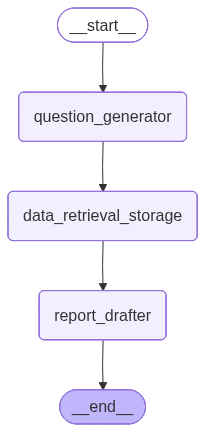

In [58]:
try:
    display(Image(competitive_analysis.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print("some error")
    pass

In [65]:
def run_data_retrieval_storage(state: CompetitiveAnalysisState) -> CompetitiveAnalysisState:
    print("[NODE]: run_data_retrieval_storage")
    if not state.question_list:
        state.error_message = "No questions generated."
        return state

    human_message_content = f"Questions: {state.question_list}"
    print(f"Invoking data_retrieval_storage_agent with: {human_message_content}")
    response = data_retrieval_storage_agent.invoke({"messages": [HumanMessage(content=human_message_content)]})

    qna_results_from_tool = None
    chromadb_status_from_tool = None

    # Iterate through messages to find specific tool outputs
    # Iterate in reverse as the latest tool outputs are usually towards the end
    for msg in reversed(response.get("messages", [])):
        if hasattr(msg, "type") and msg.type == "tool" and hasattr(msg, "name"):
            if msg.name == "fetch_search_results":
                try:
                    # Assuming fetch_search_results returns a JSON string of List[Dict]
                    qna_results_from_tool = json.loads(msg.content)
                    print(f"[FETCH SEARCH RESULTS]: Found {len(qna_results_from_tool)} results.")
                except json.JSONDecodeError as e:
                    state.error_message = f"Failed to parse fetch_search_results output: {str(e)}"
                    print(f"[ERROR]: {state.error_message}")
                # Only extract the first occurrence (most recent if iterating in reverse)
                if qna_results_from_tool is not None: continue

            elif msg.name == "store_in_chromadb":
                try:
                    # Assuming store_in_chromadb returns a JSON string of Dict {"chromadb_insert_status": bool}
                    chromadb_output = json.loads(msg.content)
                    chromadb_status_from_tool = chromadb_output.get("chromadb_insert_status", False)
                    print(f"[CHROMADB INSERT STATUS]: {chromadb_status_from_tool}")
                except json.JSONDecodeError as e:
                    state.error_message = f"Failed to parse store_in_chromadb output: {str(e)}"
                    print(f"[ERROR]: {state.error_message}")
                # Only extract the first occurrence (most recent if iterating in reverse)
                if chromadb_status_from_tool is not None: continue


    # Update state based on extracted tool outputs
    if qna_results_from_tool is None:
        state.error_message = state.error_message or "Could not find valid output from 'fetch_search_results' tool."
        print(f"[ERROR]: {state.error_message}")
        state.qna_results = [] # Ensure it's an empty list if not found
    else:
        state.qna_results = qna_results_from_tool

    if chromadb_status_from_tool is None:
        state.error_message = state.error_message or "Could not find valid output from 'store_in_chromadb' tool."
        print(f"[ERROR]: {state.error_message}")
        state.chromadb_insert_status = False # Ensure it's False if not found
    else:
        state.chromadb_insert_status = chromadb_status_from_tool

    return state

# **Execution (1 Marks)**

Invoking the workflow with the company  name as input.

In [61]:
# sample input -> Tesla, Infosys, Deloitte, Great Learning
# Input configuration
input_state = {
    "company_name": "AbbVie",
    "max_num_of_questions": 5
}

# Run the pipeline
result = competitive_analysis.invoke(input_state)

# Display the final report
display(Markdown(result['report']))

[NODE]: run_question_generator
[INSIDE TOOL] suggest_questions
[Identified SECTOR] Pharmaceuticals
[IS VALID COMPANY] True
[QUESTION GENERATED LIST] 5 questions
[PARSED OUTPUT]: sector=Pharmaceuticals, is_valid_company=True, questions=5
[NODE]: run_data_retrieval_storage
[NODE]: run_report_drafter
[RETRIEVED CONTEXT]: abbvie's products compete with similar offerings from other pharmaceutical companies in terms of pricing, efficacy, and technology, particularly in immunology and oncology segments. pricing strategies...
[REPORT GENERATED]: # AbbVie Competitor Analysis Report

## Overview
AbbVie operates in the highly competitive Pharmaceuticals sector, focusing primarily on immunology and oncology. The company’s product offerings are ch...


# AbbVie Competitor Analysis Report

## Overview
AbbVie operates in the highly competitive Pharmaceuticals sector, focusing primarily on immunology and oncology. The company’s product offerings are characterized by their innovative biologics and proprietary therapies, which provide a competitive edge in a market that is increasingly driven by efficacy, pricing, and technological advancements.

## Market Positioning
AbbVie’s strategic focus on biologics and proprietary therapies enhances its market positioning. The company employs competitive pricing strategies and emphasizes innovation to differentiate its products from those of key competitors. 

### Key Competitors
AbbVie faces significant competition from several major pharmaceutical companies, including:
- **Johnson & Johnson**
- **Pfizer**
- **Roche**
- **Merck**
- **Amgen**
- **AstraZeneca**
- **Eli Lilly**

Among these, Merck is a direct competitor, particularly in the oncology and immunotherapy segments, where both companies are vying for market share.

## Strengths and Weaknesses
### Strengths
- **Robust Portfolios**: AbbVie has strong offerings in immunology and oncology, which are critical growth areas in the pharmaceutical market.
- **Innovation**: The company’s commitment to research and development allows it to introduce cutting-edge therapies that meet evolving patient needs.

### Weaknesses
- **Patent Expirations**: AbbVie faces challenges from the expiration of patents on key products, which can lead to increased competition from biosimilars.
- **Biosimilar Competition**: The rise of biosimilars poses a threat to AbbVie’s market share and pricing power.

## Market Trends
Current trends in the pharmaceutical sector include:
- **Rising Demand for Biologics**: There is an increasing preference for biologics and targeted therapies, which AbbVie is well-positioned to capitalize on.
- **Digital Transformation**: The integration of digital technologies in pharmaceutical manufacturing is reshaping the industry, offering opportunities for efficiency and innovation.

## Strategic Recommendations
To enhance its competitive position, AbbVie should consider the following strategies:
1. **Focus on High-Growth Therapies**: Invest in the development of therapies that target high-growth areas within immunology and oncology.
2. **Digital Transformation**: Leverage AI and advanced drug delivery systems to improve manufacturing processes and enhance product offerings.
3. **Strategic Acquisitions**: Pursue acquisitions that complement AbbVie’s existing portfolio and expand its capabilities in high-demand therapeutic areas.
4. **Partnerships and Collaborations**: Engage in international collaborations to bolster market presence and share resources for research and development.

## Conclusion
AbbVie is well-positioned in the Pharmaceuticals sector, particularly in immunology and oncology, but must navigate challenges such as patent expirations and increasing biosimilar competition. By focusing on innovation, digital transformation, and strategic partnerships, AbbVie can strengthen its market position and continue to thrive in a competitive landscape.

For better readability, displaying the report in Markdown format

In [62]:
display(Markdown(result['report']))

# AbbVie Competitor Analysis Report

## Overview
AbbVie operates in the highly competitive Pharmaceuticals sector, focusing primarily on immunology and oncology. The company’s product offerings are characterized by their innovative biologics and proprietary therapies, which provide a competitive edge in a market that is increasingly driven by efficacy, pricing, and technological advancements.

## Market Positioning
AbbVie’s strategic focus on biologics and proprietary therapies enhances its market positioning. The company employs competitive pricing strategies and emphasizes innovation to differentiate its products from those of key competitors. 

### Key Competitors
AbbVie faces significant competition from several major pharmaceutical companies, including:
- **Johnson & Johnson**
- **Pfizer**
- **Roche**
- **Merck**
- **Amgen**
- **AstraZeneca**
- **Eli Lilly**

Among these, Merck is a direct competitor, particularly in the oncology and immunotherapy segments, where both companies are vying for market share.

## Strengths and Weaknesses
### Strengths
- **Robust Portfolios**: AbbVie has strong offerings in immunology and oncology, which are critical growth areas in the pharmaceutical market.
- **Innovation**: The company’s commitment to research and development allows it to introduce cutting-edge therapies that meet evolving patient needs.

### Weaknesses
- **Patent Expirations**: AbbVie faces challenges from the expiration of patents on key products, which can lead to increased competition from biosimilars.
- **Biosimilar Competition**: The rise of biosimilars poses a threat to AbbVie’s market share and pricing power.

## Market Trends
Current trends in the pharmaceutical sector include:
- **Rising Demand for Biologics**: There is an increasing preference for biologics and targeted therapies, which AbbVie is well-positioned to capitalize on.
- **Digital Transformation**: The integration of digital technologies in pharmaceutical manufacturing is reshaping the industry, offering opportunities for efficiency and innovation.

## Strategic Recommendations
To enhance its competitive position, AbbVie should consider the following strategies:
1. **Focus on High-Growth Therapies**: Invest in the development of therapies that target high-growth areas within immunology and oncology.
2. **Digital Transformation**: Leverage AI and advanced drug delivery systems to improve manufacturing processes and enhance product offerings.
3. **Strategic Acquisitions**: Pursue acquisitions that complement AbbVie’s existing portfolio and expand its capabilities in high-demand therapeutic areas.
4. **Partnerships and Collaborations**: Engage in international collaborations to bolster market presence and share resources for research and development.

## Conclusion
AbbVie is well-positioned in the Pharmaceuticals sector, particularly in immunology and oncology, but must navigate challenges such as patent expirations and increasing biosimilar competition. By focusing on innovation, digital transformation, and strategic partnerships, AbbVie can strengthen its market position and continue to thrive in a competitive landscape.